In [18]:
import sys
import os
import json
import warnings
from pathlib import Path

# CRITICAL FIX: Prevent OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# SEM / CFA
import semopy
from semopy import Model

# Reliability calculations
import pingouin as pg

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ semopy version: {semopy.__version__}")

✓ Libraries loaded
✓ Random seed: 67
✓ semopy version: 2.3.11


## 1. Load Data and EFA Solution

In [19]:
# Load holdout sample for CFA validation
df_holdout = pd.read_csv('data/AIRS_holdout.csv')

# Load EFA solution from Phase 1
with open('data/efa_solution.json', 'r') as f:
    efa_solution = json.load(f)

# Load item metadata
with open('../data/airs_28item_complete.json', 'r') as f:
    item_metadata = json.load(f)

metadata = item_metadata['metadata']

print(f"📊 Full Sample CFA Validation")
print(f"   EFA Development N: {efa_solution['n_dev']}")
print(f"   CFA Holdout N: {len(df_holdout)}")
print(f"\nEFA Solution:")
print(f"   Factors: {efa_solution['n_factors']}")
print(f"   Variance Explained: {efa_solution['total_variance_explained']*100:.1f}%")
print(f"   Method: {efa_solution['method']} with {efa_solution['rotation']} rotation")

📊 Full Sample CFA Validation
   EFA Development N: 255
   CFA Holdout N: 256

EFA Solution:
   Factors: 2
   Variance Explained: 51.2%
   Method: minres with promax rotation


In [20]:
# Extract factor structure from EFA
n_factors = efa_solution['n_factors']
items_per_factor = efa_solution['items_per_factor']
problem_items = efa_solution['problem_items']

print("Factor Structure from EFA:")
for factor, items in items_per_factor.items():
    reliability = efa_solution['reliability'].get(factor, 'N/A')
    print(f"\n{factor}: {len(items)} items (α = {reliability:.3f})")
    print(f"   Items: {', '.join(items)}")

print(f"\n⚠️ Problem items from EFA: {problem_items}")

Factor Structure from EFA:

F1: 20 items (α = 0.953)
   Items: PE1, PE2, EE1, EE2, SI1, SI2, FC1, FC2, HM1, HM2, PV1, PV2, HB1, HB2, VO1, VO2, TR1, TR2, EX1, EX2

F2: 4 items (α = 0.681)
   Items: ER1, ER2, AX1, AX2

⚠️ Problem items from EFA: ['SI2', 'FC1', 'VO2', 'EX1', 'EX2', 'ER1', 'AX1', 'AX2']


## 2. Sample Adequacy Check

In [21]:
# Get all items for CFA
all_items = []
for items in items_per_factor.values():
    all_items.extend(items)

# Create analysis dataframe
df_cfa = df_holdout[all_items].copy()

# Sample size considerations
n_holdout = len(df_holdout)
n_items = len(all_items)
n_params = n_items * 2 + n_factors  # loadings + error variances + factor variances

print(f"Sample Size Assessment:")
print(f"   N = {n_holdout}")
print(f"   Items = {n_items}")
print(f"   Estimated parameters ≈ {n_params}")
print(f"   N:parameter ratio = {n_holdout/n_params:.1f}:1")

if n_holdout >= 200:
    print(f"\n✓ Adequate sample size for CFA (N ≥ 200)")
elif n_holdout >= 100:
    print(f"\n⚠️ Marginal sample size - consider bootstrap estimation")
else:
    print(f"\n❌ Small sample - bootstrap estimation required")

# Missing data check
missing = df_cfa.isnull().sum().sum()
print(f"\nMissing data: {missing} values")

Sample Size Assessment:
   N = 256
   Items = 24
   Estimated parameters ≈ 50
   N:parameter ratio = 5.1:1

✓ Adequate sample size for CFA (N ≥ 200)

Missing data: 0 values


## 3. Build CFA Model Specification

In [22]:
# Build semopy model syntax
# Factor names based on content interpretation
factor_names = {
    'F1': 'Facilitators',  # PE, EE, SI, FC, HM, PV, HB, VO, TR, EX
    'F2': 'Inhibitors'     # ER, AX
}

# Create model syntax
model_lines = []

for factor, items in items_per_factor.items():
    factor_label = factor_names.get(factor, factor)
    items_str = ' + '.join(items)
    model_lines.append(f"{factor_label} =~ {items_str}")

# Add factor covariance (allow factors to correlate)
if n_factors == 2:
    model_lines.append("Facilitators ~~ Inhibitors")

model_syntax = '\n'.join(model_lines)

print("CFA Model Specification:")
print("=" * 50)
print(model_syntax)
print("=" * 50)

CFA Model Specification:
Facilitators =~ PE1 + PE2 + EE1 + EE2 + SI1 + SI2 + FC1 + FC2 + HM1 + HM2 + PV1 + PV2 + HB1 + HB2 + VO1 + VO2 + TR1 + TR2 + EX1 + EX2
Inhibitors =~ ER1 + ER2 + AX1 + AX2
Facilitators ~~ Inhibitors


In [23]:
# Fit CFA model
model = Model(model_syntax)
model.fit(df_cfa)

# Get fit statistics
fit_stats = semopy.calc_stats(model)

print("Model Fit Statistics:")
print("=" * 50)
for stat in fit_stats.columns:
    value = fit_stats.loc['Value', stat]
    if isinstance(value, (int, float)) and not np.isnan(value):
        print(f"   {stat}: {value:.4f}")
    else:
        print(f"   {stat}: {value}")

Model Fit Statistics:
   DoF: 251
   DoF Baseline: 276
   chi2: 1058.4890
   chi2 p-value: 0.0000
   chi2 Baseline: 4736.8848
   CFI: 0.8190
   GFI: 0.7765
   AGFI: 0.7543
   NFI: 0.7765
   TLI: 0.8010
   RMSEA: 0.1123
   AIC: 89.7306
   BIC: 263.4442
   LogLik: 4.1347


## 4. Evaluate Model Fit

In [24]:
# Extract key fit indices (stats are in columns, 'Value' is the index)
chi2 = fit_stats.loc['Value', 'chi2'] if 'chi2' in fit_stats.columns else None
df_fit = fit_stats.loc['Value', 'DoF'] if 'DoF' in fit_stats.columns else None
cfi = fit_stats.loc['Value', 'CFI'] if 'CFI' in fit_stats.columns else None
tli = fit_stats.loc['Value', 'TLI'] if 'TLI' in fit_stats.columns else None
rmsea = fit_stats.loc['Value', 'RMSEA'] if 'RMSEA' in fit_stats.columns else None
srmr = None  # semopy doesn't provide SRMR by default
aic = fit_stats.loc['Value', 'AIC'] if 'AIC' in fit_stats.columns else None
bic = fit_stats.loc['Value', 'BIC'] if 'BIC' in fit_stats.columns else None

# Create fit assessment table
fit_criteria = {
    'CFI': {'value': cfi, 'good': '>= 0.95', 'acceptable': '>= 0.90', 
            'status': '✓ Good' if cfi and cfi >= 0.95 else ('⚠️ Acceptable' if cfi and cfi >= 0.90 else '❌ Poor')},
    'TLI': {'value': tli, 'good': '>= 0.95', 'acceptable': '>= 0.90',
            'status': '✓ Good' if tli and tli >= 0.95 else ('⚠️ Acceptable' if tli and tli >= 0.90 else '❌ Poor')},
    'RMSEA': {'value': rmsea, 'good': '<= 0.06', 'acceptable': '<= 0.08',
              'status': '✓ Good' if rmsea and rmsea <= 0.06 else ('⚠️ Acceptable' if rmsea and rmsea <= 0.08 else '❌ Poor')},
    'SRMR': {'value': srmr, 'good': '<= 0.08', 'acceptable': '<= 0.10',
             'status': '✓ Good' if srmr and srmr <= 0.08 else ('⚠️ Acceptable' if srmr and srmr <= 0.10 else '❌ Poor')}
}

print("\nModel Fit Assessment:")
print("=" * 70)
print(f"{'Index':<10} {'Value':<12} {'Good':<15} {'Acceptable':<15} {'Status':<15}")
print("-" * 70)
for index, criteria in fit_criteria.items():
    val = f"{criteria['value']:.4f}" if criteria['value'] else 'N/A'
    print(f"{index:<10} {val:<12} {criteria['good']:<15} {criteria['acceptable']:<15} {criteria['status']:<15}")
print("=" * 70)

if chi2 and df_fit:
    chi2_df_ratio = chi2 / df_fit
    print(f"\nχ²/df ratio: {chi2_df_ratio:.2f} ({'Good' if chi2_df_ratio < 3 else 'Acceptable' if chi2_df_ratio < 5 else 'Poor'})")


Model Fit Assessment:
Index      Value        Good            Acceptable      Status         
----------------------------------------------------------------------
CFI        0.8190       >= 0.95         >= 0.90         ❌ Poor         
TLI        0.8010       >= 0.95         >= 0.90         ❌ Poor         
RMSEA      0.1123       <= 0.06         <= 0.08         ❌ Poor         
SRMR       N/A          <= 0.08         <= 0.10         ❌ Poor         

χ²/df ratio: 4.22 (Acceptable)


## 5. Factor Loadings and Reliability

In [25]:
# Get parameter estimates (standardized)
params = model.inspect(std_est=True)

# Extract factor loadings (lval=Item, rval=Factor in semopy syntax)
loadings_df = params[params['op'] == '~'].copy()

# Use standardized estimates if available
if 'Est. Std' in loadings_df.columns:
    loadings_df = loadings_df[['rval', 'lval', 'Est. Std', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']
else:
    loadings_df = loadings_df[['rval', 'lval', 'Estimate', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']

# Add construct info
loadings_df['Construct'] = loadings_df['Item'].apply(lambda x: metadata[x]['construct_abbr'] if x in metadata else 'Unknown')

# Add significance stars (handle '-' for fixed parameters)
def get_sig(p):
    if isinstance(p, str) or pd.isna(p):
        return '(fixed)'
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

loadings_df['Sig'] = loadings_df['p'].apply(get_sig)

print("Factor Loadings (Standardized):")
print("=" * 80)
display(loadings_df.round(4))

Factor Loadings (Standardized):


,Factor,Item,Loading,SE,z,p,Construct,Sig
0,Facilitators,PE1,0.7583,-,-,-,PE,(fixed)
1,Facilitators,PE2,0.7950,0.082741,13.669749,0.0,PE,***
2,Facilitators,EE1,0.5759,0.072418,9.477577,0.0,EE,***
3,Facilitators,EE2,0.6477,0.073244,10.791947,0.0,EE,***
4,Facilitators,SI1,0.7807,0.080693,13.377792,0.0,SI,***
5,Facilitators,SI2,0.6197,0.076862,10.27305,0.0,SI,***
6,Facilitators,FC1,0.6295,0.080457,10.455039,0.0,FC,***
7,Facilitators,FC2,0.7080,0.067299,11.937803,0.0,FC,***
8,Facilitators,HM1,0.8470,0.078869,14.75645,0.0,HM,***
9,Facilitators,HM2,0.8651,0.081141,15.146732,0.0,HM,***


In [26]:
# Calculate reliability metrics per factor
def calculate_composite_reliability(loadings):
    """Calculate Composite Reliability (CR) from standardized loadings."""
    sum_loadings = sum(loadings)
    sum_loadings_sq = sum_loadings ** 2
    sum_error_var = sum(1 - l**2 for l in loadings)
    cr = sum_loadings_sq / (sum_loadings_sq + sum_error_var)
    return cr

def calculate_ave(loadings):
    """Calculate Average Variance Extracted (AVE) from standardized loadings."""
    return np.mean([l**2 for l in loadings])

# Calculate reliability for each factor
reliability_results = []

for factor in loadings_df['Factor'].unique():
    factor_loadings = loadings_df[loadings_df['Factor'] == factor]['Loading'].values
    factor_items = loadings_df[loadings_df['Factor'] == factor]['Item'].tolist()
    
    # Composite reliability
    cr = calculate_composite_reliability(factor_loadings)
    
    # AVE
    ave = calculate_ave(factor_loadings)
    
    # Cronbach's alpha from data
    if len(factor_items) >= 2:
        alpha_result = pg.cronbach_alpha(df_cfa[factor_items])
        alpha = alpha_result[0]
    else:
        alpha = np.nan
    
    reliability_results.append({
        'Factor': factor,
        'N_Items': len(factor_items),
        'Cronbach_Alpha': alpha,
        'Composite_Reliability': cr,
        'AVE': ave,
        'CR_Status': '✓' if cr >= 0.70 else '⚠️',
        'AVE_Status': '✓' if ave >= 0.50 else '⚠️'
    })

reliability_df = pd.DataFrame(reliability_results)

print("\nReliability Assessment:")
print("=" * 80)
print("Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70")
print("-" * 80)
display(reliability_df.round(4))


Reliability Assessment:
Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70
--------------------------------------------------------------------------------


,Factor,N_Items,Cronbach_Alpha,Composite_Reliability,AVE,CR_Status,AVE_Status
0,Facilitators,20,0.9569,0.9568,0.5376,✓,✓
1,Inhibitors,4,0.6357,0.6403,0.3716,⚠️,⚠️


## 6. Discriminant Validity

In [27]:
# Get factor correlations
factor_corr_params = params[(params['op'] == '~~') & (params['lval'] != params['rval'])]

if len(factor_corr_params) > 0:
    factor_corr = factor_corr_params['Estimate'].values[0]
    factor_corr_sq = factor_corr ** 2
    
    # AVE for each factor
    ave_values = {row['Factor']: row['AVE'] for _, row in reliability_df.iterrows()}
    
    print("Discriminant Validity Assessment (Fornell-Larcker Criterion):")
    print("=" * 60)
    print(f"\nFactor Correlation: r = {factor_corr:.4f}")
    print(f"Shared Variance (r²): {factor_corr_sq:.4f}")
    print(f"\nAVE values:")
    for factor, ave in ave_values.items():
        print(f"   {factor}: {ave:.4f}")
    
    # Check Fornell-Larcker
    min_ave = min(ave_values.values())
    if factor_corr_sq < min_ave:
        print(f"\n✓ Discriminant validity supported: r² ({factor_corr_sq:.4f}) < min AVE ({min_ave:.4f})")
    else:
        print(f"\n⚠️ Discriminant validity concern: r² ({factor_corr_sq:.4f}) ≥ min AVE ({min_ave:.4f})")
else:
    print("Factor correlations not found in model output")

Discriminant Validity Assessment (Fornell-Larcker Criterion):

Factor Correlation: r = -0.2460
Shared Variance (r²): 0.0605

AVE values:
   Facilitators: 0.5376
   Inhibitors: 0.3716

✓ Discriminant validity supported: r² (0.0605) < min AVE (0.3716)


## 7. Visualizations

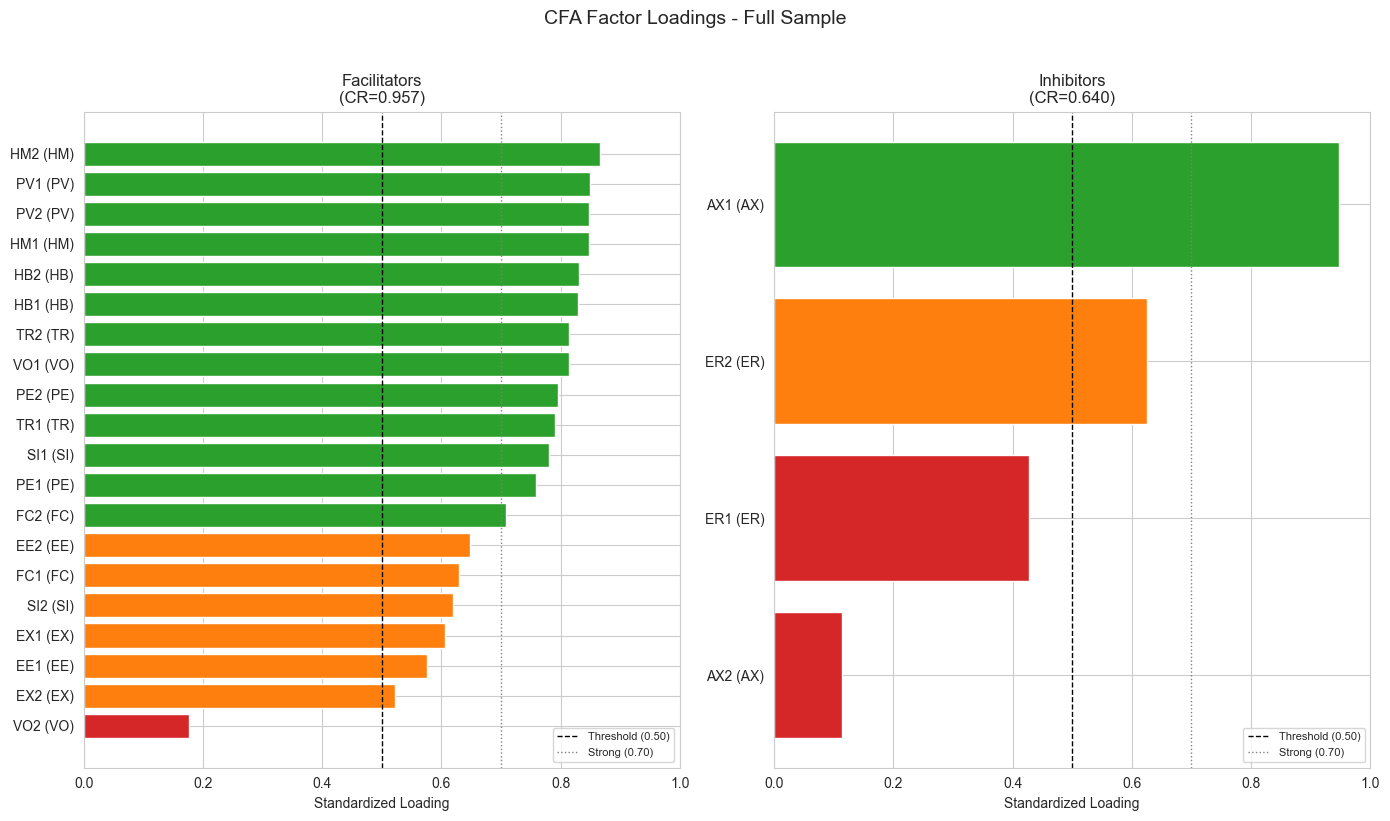

✓ Loading chart saved to plots/02_cfa_loadings.png


In [28]:
# Factor Loading Bar Chart
fig, axes = plt.subplots(1, n_factors, figsize=(14, 8))

if n_factors == 1:
    axes = [axes]

for idx, factor in enumerate(loadings_df['Factor'].unique()):
    ax = axes[idx]
    factor_data = loadings_df[loadings_df['Factor'] == factor].sort_values('Loading', ascending=True)
    
    colors = ['#2ca02c' if l >= 0.7 else '#ff7f0e' if l >= 0.5 else '#d62728' for l in factor_data['Loading']]
    
    bars = ax.barh(range(len(factor_data)), factor_data['Loading'], color=colors)
    ax.set_yticks(range(len(factor_data)))
    ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in factor_data.iterrows()])
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Threshold (0.50)')
    ax.axvline(x=0.7, color='gray', linestyle=':', linewidth=1, label='Strong (0.70)')
    ax.set_xlabel('Standardized Loading')
    ax.set_title(f'{factor}\n(CR={reliability_df[reliability_df["Factor"]==factor]["Composite_Reliability"].values[0]:.3f})')
    ax.set_xlim(0, 1)
    ax.legend(loc='lower right', fontsize=8)

plt.suptitle('CFA Factor Loadings - Full Sample', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/02_cfa_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Loading chart saved to plots/02_cfa_loadings.png")

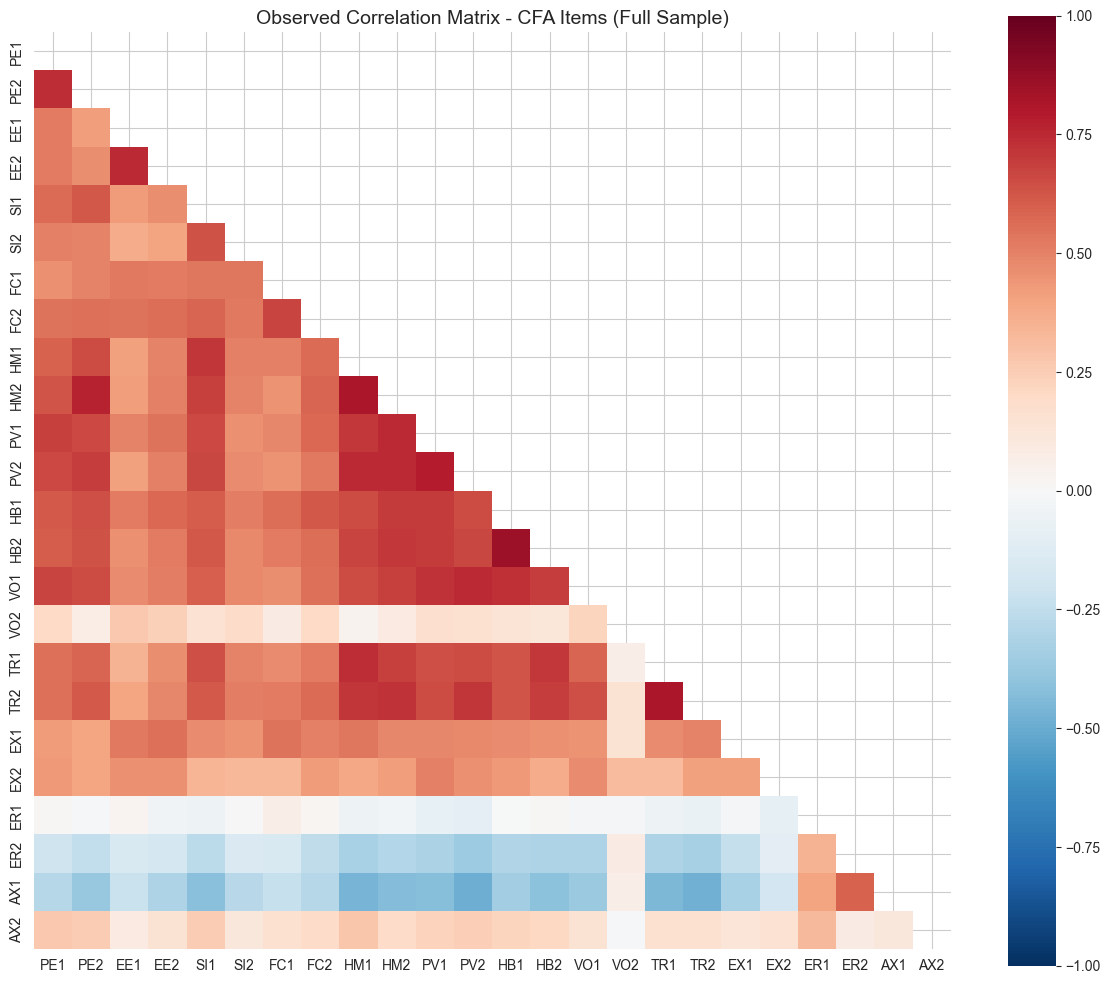

✓ Correlation matrix saved to plots/02_correlation_matrix.png


In [29]:
# Residual correlation matrix (for model diagnostics)
# Calculate implied vs observed correlations
observed_corr = df_cfa.corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(observed_corr, dtype=bool))
sns.heatmap(observed_corr, mask=mask, annot=False, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Observed Correlation Matrix - CFA Items (Full Sample)', fontsize=14)
plt.tight_layout()
plt.savefig('plots/02_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Correlation matrix saved to plots/02_correlation_matrix.png")

## 8. Export Results

In [30]:
# Save factor loadings
loadings_df.to_csv('tables/02_cfa_loadings.csv', index=False)

# Save reliability metrics
reliability_df.to_csv('tables/02_cfa_reliability.csv', index=False)

# Save fit statistics
fit_stats.to_csv('tables/02_cfa_fit_statistics.csv')

# Create CFA solution JSON for downstream
cfa_solution = {
    'population': 'full',
    'n_holdout': n_holdout,
    'n_factors': n_factors,
    'factor_names': factor_names,
    'fit_indices': {
        'chi2': float(chi2) if chi2 else None,
        'df': int(df_fit) if df_fit else None,
        'CFI': float(cfi) if cfi else None,
        'TLI': float(tli) if tli else None,
        'RMSEA': float(rmsea) if rmsea else None,
        'SRMR': float(srmr) if srmr else None,
        'AIC': float(aic) if aic else None,
        'BIC': float(bic) if bic else None
    },
    'reliability': {
        row['Factor']: {
            'alpha': float(row['Cronbach_Alpha']),
            'CR': float(row['Composite_Reliability']),
            'AVE': float(row['AVE'])
        } for _, row in reliability_df.iterrows()
    },
    'items_per_factor': items_per_factor
}

with open('data/cfa_solution.json', 'w') as f:
    json.dump(cfa_solution, f, indent=2)

print("✓ Results exported:")
print("   - tables/02_cfa_loadings.csv")
print("   - tables/02_cfa_reliability.csv")
print("   - tables/02_cfa_fit_statistics.csv")
print("   - data/cfa_solution.json")

✓ Results exported:
   - tables/02_cfa_loadings.csv
   - tables/02_cfa_reliability.csv
   - tables/02_cfa_fit_statistics.csv
   - data/cfa_solution.json


## 9. Summary & Recommendations

In [31]:
print("=" * 60)
print("CFA SUMMARY - FULL SAMPLE")
print("=" * 60)
print(f"\nSample: N = {n_holdout} (holdout)")
print(f"Model: {n_factors}-factor solution from EFA")

print(f"\nModel Fit:")
for index, criteria in fit_criteria.items():
    val = f"{criteria['value']:.4f}" if criteria['value'] else 'N/A'
    print(f"   {index}: {val} {criteria['status']}")

print(f"\nReliability:")
for _, row in reliability_df.iterrows():
    print(f"   {row['Factor']}: CR={row['Composite_Reliability']:.3f}, AVE={row['AVE']:.3f}, α={row['Cronbach_Alpha']:.3f}")

# Overall assessment
good_fit = (cfi and cfi >= 0.90) and (rmsea and rmsea <= 0.08)
good_reliability = all(reliability_df['Composite_Reliability'] >= 0.70)
good_ave = all(reliability_df['AVE'] >= 0.50)

print(f"\nOverall Assessment:")
print(f"   Model Fit: {'✓ Acceptable' if good_fit else '⚠️ Needs improvement'}")
print(f"   Reliability: {'✓ Good' if good_reliability else '⚠️ Issues detected'}")
print(f"   Convergent Validity (AVE): {'✓ Good' if good_ave else '⚠️ Issues detected'}")

CFA SUMMARY - FULL SAMPLE

Sample: N = 256 (holdout)
Model: 2-factor solution from EFA

Model Fit:
   CFI: 0.8190 ❌ Poor
   TLI: 0.8010 ❌ Poor
   RMSEA: 0.1123 ❌ Poor
   SRMR: N/A ❌ Poor

Reliability:
   Facilitators: CR=0.957, AVE=0.538, α=0.957
   Inhibitors: CR=0.640, AVE=0.372, α=0.636

Overall Assessment:
   Model Fit: ⚠️ Needs improvement
   Reliability: ⚠️ Issues detected
   Convergent Validity (AVE): ⚠️ Issues detected


In [32]:
# Recommendations
print("\nRECOMMENDATIONS:")
print("-" * 40)

if not good_fit:
    print("\n1. Model fit improvement:")
    print("   - Review modification indices for correlated errors")
    print("   - Consider removing items with low loadings")
    print("   - Check for cross-loadings suggested by MI")

if not good_reliability:
    low_cr = reliability_df[reliability_df['Composite_Reliability'] < 0.70]
    if len(low_cr) > 0:
        print(f"\n2. Reliability concerns:")
        for _, row in low_cr.iterrows():
            print(f"   - {row['Factor']}: CR = {row['Composite_Reliability']:.3f}")

if not good_ave:
    low_ave = reliability_df[reliability_df['AVE'] < 0.50]
    if len(low_ave) > 0:
        print(f"\n3. Convergent validity concerns:")
        for _, row in low_ave.iterrows():
            print(f"   - {row['Factor']}: AVE = {row['AVE']:.3f}")

# Low loadings
low_loadings = loadings_df[loadings_df['Loading'] < 0.50]
if len(low_loadings) > 0:
    print(f"\n4. Items with loading < 0.50:")
    for _, row in low_loadings.iterrows():
        print(f"   - {row['Item']} ({row['Construct']}): λ = {row['Loading']:.3f}")

print(f"\n5. Next Steps:")
print(f"   - Compare with Academic and Professional CFA solutions")
print(f"   - Test measurement invariance across populations")
print(f"   - Proceed to structural model (Notebook 04)")


RECOMMENDATIONS:
----------------------------------------

1. Model fit improvement:
   - Review modification indices for correlated errors
   - Consider removing items with low loadings
   - Check for cross-loadings suggested by MI

2. Reliability concerns:
   - Inhibitors: CR = 0.640

3. Convergent validity concerns:
   - Inhibitors: AVE = 0.372

4. Items with loading < 0.50:
   - VO2 (VO): λ = 0.177
   - ER1 (ER): λ = 0.427
   - AX2 (AX): λ = 0.114

5. Next Steps:
   - Compare with Academic and Professional CFA solutions
   - Test measurement invariance across populations
   - Proceed to structural model (Notebook 04)


## 10. APA Method Summary

In [33]:
# Format values for APA summary
chi2_str = f"{chi2:.2f}" if chi2 else 'NA'
df_str = f"{int(df_fit)}" if df_fit else 'NA'
cfi_str = f"{cfi:.3f}" if cfi else 'NA'
tli_str = f"{tli:.3f}" if tli else 'NA'
rmsea_str = f"{rmsea:.3f}" if rmsea else 'NA'
srmr_str = f"{srmr:.3f}" if srmr else 'NA'
fit_desc = 'acceptable' if good_fit else 'marginal'
rel_desc = 'All factors demonstrated acceptable reliability (CR ≥ .70).' if good_reliability else 'Some factors showed reliability concerns.'
ave_desc = 'All factors met the .50 threshold for AVE.' if good_ave else 'Some factors showed AVE below the .50 threshold.'

apa_summary = f"""
### Method Summary (APA Format)

**Confirmatory Factor Analysis - Full Sample**

The {n_factors}-factor structure identified in exploratory factor analysis was validated using 
confirmatory factor analysis (CFA) on the independent holdout sample (*N* = {n_holdout}). 
The model was estimated using maximum likelihood estimation in semopy (Python).

The hypothesized {n_factors}-factor model demonstrated {fit_desc} fit 
to the data: χ²({df_str}) = {chi2_str}, 
CFI = {cfi_str}, TLI = {tli_str}, 
RMSEA = {rmsea_str}, SRMR = {srmr_str}.

Reliability was assessed using composite reliability (CR) and Cronbach's alpha. 
{rel_desc}
Convergent validity was evaluated using average variance extracted (AVE). 
{ave_desc}

The factor structure will be further validated through measurement invariance testing 
across academic and professional subsamples.
"""

display(Markdown(apa_summary))


### Method Summary (APA Format)

**Confirmatory Factor Analysis - Full Sample**

The 2-factor structure identified in exploratory factor analysis was validated using 
confirmatory factor analysis (CFA) on the independent holdout sample (*N* = 256). 
The model was estimated using maximum likelihood estimation in semopy (Python).

The hypothesized 2-factor model demonstrated marginal fit 
to the data: χ²(251) = 1058.49, 
CFI = 0.819, TLI = 0.801, 
RMSEA = 0.112, SRMR = NA.

Reliability was assessed using composite reliability (CR) and Cronbach's alpha. 
Some factors showed reliability concerns.
Convergent validity was evaluated using average variance extracted (AVE). 
Some factors showed AVE below the .50 threshold.

The factor structure will be further validated through measurement invariance testing 
across academic and professional subsamples.
